# MovieMind - Clustering Analysis

This notebook performs k-means clustering to find similar movies and audience patterns.

## Contents:
1. Data Loading and Preparation
2. Feature Engineering
3. Elbow Method (Optimal k)
4. K-means Clustering
5. Silhouette Analysis
6. Cluster Interpretation
7. Visualization

In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

from src.utils.db_manager import DatabaseManager
from src.preprocessing.text_processor import TextProcessor
from src.models.clustering import MovieClusterer

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading and Preparation

In [2]:
# Load data from database
with DatabaseManager() as db:
    query = """
    SELECT 
        m.movie_id,
        m.title,
        m.genres,
        m.vote_average,
        m.vote_count,
        m.popularity,
        m.runtime,
        m.budget,
        m.revenue,
        m.overview,
        m.release_date,
        COUNT(r.review_id) as review_count,
        AVG(r.sentiment_score) as avg_sentiment
    FROM movies m
    LEFT JOIN reviews r ON m.movie_id = r.movie_id
    GROUP BY m.movie_id, m.title, m.genres, m.vote_average, m.vote_count, 
             m.popularity, m.runtime, m.budget, m.revenue, m.overview, m.release_date
    HAVING COUNT(r.review_id) > 0
    LIMIT 1000
    """
    df = pd.DataFrame(db.execute_query(query))

print(f"Loaded {len(df)} movies with reviews")
df.head()

INFO:src.utils.db_manager:Database connection established


INFO:src.utils.db_manager:Database connection closed


Loaded 54 movies with reviews


,movie_id,title,genres,vote_average,vote_count,popularity,runtime,budget,revenue,overview,release_date,review_count,avg_sentiment
0,1439112,Muzzle: City of Wolves,"[Action, Thriller, Mystery]",6.8,65,170.388,93,0,0,LAPD officer Jake Rosser endeavors to lead a p...,2025-11-13,1,None
1,539,Psycho,"[Horror, Thriller, Mystery]",8.4,10692,11.233,109,806947,50048065,When larcenous real estate clerk Marion Crane ...,1960-09-08,6,None
2,812583,Wake Up Dead Man: A Knives Out Mystery,"[Thriller, Mystery, Comedy]",7.2,1471,108.354,145,210000000,4000000,When young priest Jud Duplenticy is sent to as...,2025-11-26,3,None
3,12477,Grave of the Fireflies,"[Animation, Drama, War]",8.4,6253,0.012,89,3700000,842132,"In the final months of World War II, 14-year-o...",1988-04-16,3,None
4,1234731,Anaconda,"[Adventure, Comedy, Horror]",6.5,89,99.931,100,45000000,49571097,A group of friends facing mid-life crises head...,2025-12-24,2,None


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Fill missing values
df['runtime'] = df['runtime'].fillna(df['runtime'].median())
df['budget'] = df['budget'].fillna(0)
df['revenue'] = df['revenue'].fillna(0)
df['avg_sentiment'] = df['avg_sentiment'].fillna(0)

Missing values:
movie_id          0
title             0
genres            0
vote_average      0
vote_count        0
popularity        0
runtime           0
budget            0
revenue           0
overview          0
release_date      0
review_count      0
avg_sentiment    54
dtype: int64


## 2. Feature Engineering

In [4]:
# Extract year from release_date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df['year'] = df['year'].fillna(df['year'].median())

# Create ROI feature
df['roi'] = np.where(df['budget'] > 0, (df['revenue'] - df['budget']) / df['budget'], 0)

# Create genre features (one-hot encoding for top genres)
top_genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance', 'Adventure', 'Horror', 'Crime']

for genre in top_genres:
    df[f'genre_{genre}'] = df['genres'].apply(
        lambda x: 1 if isinstance(x, list) and genre in x else 0
    )

print("Features created:")
print(df.columns.tolist())

Features created:
['movie_id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'runtime', 'budget', 'revenue', 'overview', 'release_date', 'review_count', 'avg_sentiment', 'year', 'roi', 'genre_Drama', 'genre_Comedy', 'genre_Action', 'genre_Thriller', 'genre_Romance', 'genre_Adventure', 'genre_Horror', 'genre_Crime']


In [5]:
# Select numerical features for clustering
feature_cols = [
    'vote_average', 'vote_count', 'popularity', 'runtime', 
    'review_count', 'avg_sentiment', 'year', 'roi'
] + [f'genre_{g}' for g in top_genres]

X = df[feature_cols].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")

Feature matrix shape: (54, 16)


## 3. Elbow Method (Finding Optimal k)

In [6]:
# Calculate inertia for different k values
K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

k=2: Inertia=657.01, Silhouette=0.170
k=3: Inertia=588.49, Silhouette=0.170
k=4: Inertia=531.58, Silhouette=0.150
k=5: Inertia=489.03, Silhouette=0.166
k=6: Inertia=451.14, Silhouette=0.167
k=7: Inertia=412.45, Silhouette=0.172
k=8: Inertia=378.13, Silhouette=0.160
k=9: Inertia=359.77, Silhouette=0.171


k=10: Inertia=330.69, Silhouette=0.175


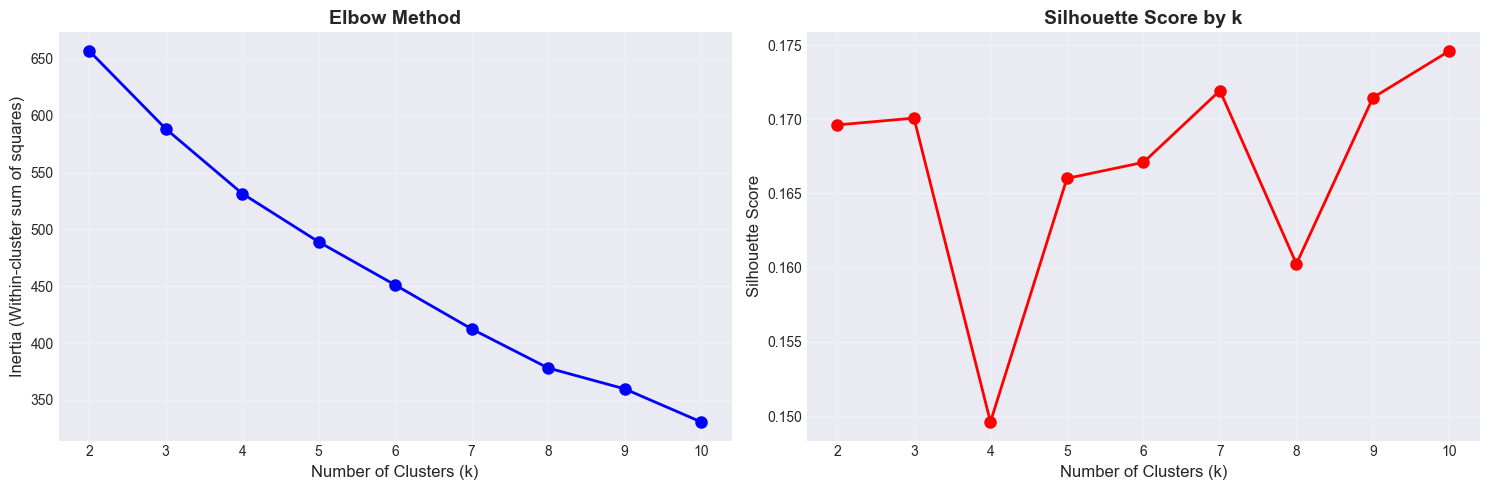


Optimal k based on Silhouette Score: 10


In [7]:
# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on Silhouette Score: {optimal_k}")

## 4. K-means Clustering with Optimal k

In [8]:
# Use optimal k (or set manually if needed)
k_final = optimal_k  # You can change this manually if needed (e.g., k_final = 5)

# Fit final model
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"Clustering with k={k_final}")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())

Clustering with k=10

Cluster distribution:
cluster
0    17
1     5
2     3
3     7
4     6
5     2
6     1
7     5
8     5
9     3
Name: count, dtype: int64


## 5. Silhouette Analysis

In [9]:
# Calculate silhouette scores
silhouette_avg = silhouette_score(X_scaled, df['cluster'])
sample_silhouette_values = silhouette_samples(X_scaled, df['cluster'])

print(f"Average Silhouette Score: {silhouette_avg:.3f}")
print(f"\nSilhouette score by cluster:")
for i in range(k_final):
    cluster_silhouette = sample_silhouette_values[df['cluster'] == i]
    print(f"  Cluster {i}: {cluster_silhouette.mean():.3f}")

Average Silhouette Score: 0.175

Silhouette score by cluster:
  Cluster 0: 0.129
  Cluster 1: 0.186
  Cluster 2: 0.568
  Cluster 3: 0.144
  Cluster 4: 0.347
  Cluster 5: 0.315
  Cluster 6: 0.000
  Cluster 7: 0.156
  Cluster 8: 0.117
  Cluster 9: -0.165


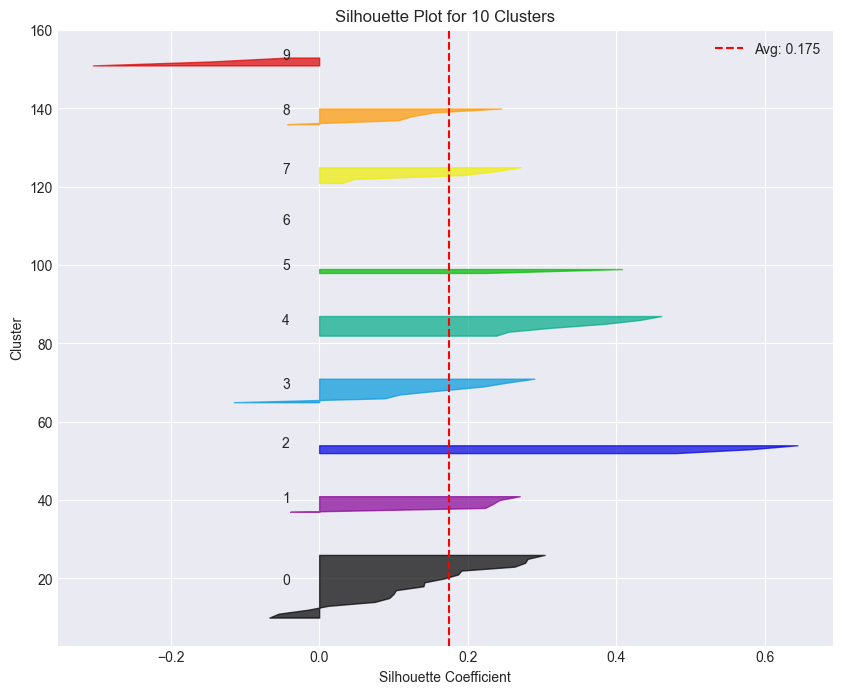

In [10]:
# Silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

y_lower = 10
for i in range(k_final):
    cluster_silhouette_values = sample_silhouette_values[df['cluster'] == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / k_final)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette Plot for {k_final} Clusters")
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg: {silhouette_avg:.3f}")
ax.legend()
plt.show()

## 6. Cluster Interpretation

In [11]:
# Analyze cluster characteristics
cluster_summary = df.groupby('cluster')[feature_cols].mean()

print("\n" + "="*80)
print("CLUSTER CHARACTERISTICS (Mean values)")
print("="*80)
display(cluster_summary.round(2))


CLUSTER CHARACTERISTICS (Mean values)


,vote_average,vote_count,popularity,runtime,review_count,avg_sentiment,year,roi,genre_Drama,genre_Comedy,genre_Action,genre_Thriller,genre_Romance,genre_Adventure,genre_Horror,genre_Crime
cluster,,,,,,,,,,,,,,,,
0,6.74,760.88,127.63,125.88,3.24,0.0,2023.65,2.64,0.29,0.18,0.71,0.71,0.0,0.12,0.0,0.24
1,8.16,3079.60,17.12,135.40,2.40,0.0,2004.80,1.52,0.80,0.40,0.00,0.00,1.0,0.00,0.2,0.00
2,8.53,15328.33,19.67,178.67,5.33,0.0,1987.67,3.85,1.00,0.00,0.00,0.00,0.0,0.00,0.0,1.00
3,8.06,15837.57,58.87,139.29,7.00,0.0,2008.14,14.40,0.00,0.14,0.57,0.00,0.0,0.86,0.0,0.00
4,8.43,5333.67,5.64,114.17,3.17,0.0,1990.00,3.48,1.00,0.17,0.17,0.00,0.0,0.00,0.0,0.00
5,8.35,8811.50,8.52,110.50,5.50,0.0,1957.00,48.53,0.00,0.00,0.00,1.00,0.0,0.00,0.5,0.00
6,8.40,16707.00,17.10,117.00,49.00,0.0,2018.00,3.37,0.00,0.00,1.00,0.00,0.0,1.00,0.0,0.00
7,6.68,624.00,117.22,108.80,5.40,0.0,2025.00,0.87,0.20,0.20,0.20,0.40,0.0,0.20,1.0,0.00
8,6.78,389.20,218.90,111.60,2.80,0.0,2025.00,2.23,0.20,0.40,0.20,0.00,0.2,1.00,0.0,0.00


In [12]:
# Sample movies from each cluster
print("\n" + "="*80)
print("SAMPLE MOVIES FROM EACH CLUSTER")
print("="*80)

for cluster_id in range(k_final):
    print(f"\n--- Cluster {cluster_id} ({(df['cluster'] == cluster_id).sum()} movies) ---")
    sample = df[df['cluster'] == cluster_id][['title', 'vote_average', 'genres', 'year']].head(5)
    for idx, row in sample.iterrows():
        genres_str = ', '.join(row['genres']) if isinstance(row['genres'], list) else 'N/A'
        print(f"  • {row['title']} ({int(row['year'])}) - Rating: {row['vote_average']:.1f} - Genres: {genres_str}")


SAMPLE MOVIES FROM EACH CLUSTER

--- Cluster 0 (17 movies) ---
  • Muzzle: City of Wolves (2025) - Rating: 6.8 - Genres: Action, Thriller, Mystery
  • Wake Up Dead Man: A Knives Out Mystery (2025) - Rating: 7.2 - Genres: Thriller, Mystery, Comedy
  • Demon Slayer: Kimetsu no Yaiba Infinity Castle (2025) - Rating: 7.6 - Genres: Animation, Action, Fantasy
  • xXx (2002) - Rating: 6.0 - Genres: Action, Adventure, Thriller, Crime, Drama
  • Kantara - A Legend: Chapter 1 (2025) - Rating: 7.0 - Genres: Action, Drama, Fantasy

--- Cluster 1 (5 movies) ---
  • Dracula (2025) - Rating: 7.1 - Genres: Horror, Fantasy, Romance
  • A Silent Voice: The Movie (2016) - Rating: 8.4 - Genres: Animation, Drama, Romance
  • A Dog's Will (2000) - Rating: 8.4 - Genres: Comedy, Drama, Fantasy, Romance
  • Dilwale Dulhania Le Jayenge (1995) - Rating: 8.5 - Genres: Comedy, Drama, Romance
  • Cinema Paradiso (1988) - Rating: 8.4 - Genres: Drama, Romance

--- Cluster 2 (3 movies) ---
  • GoodFellas (1990) - Rat

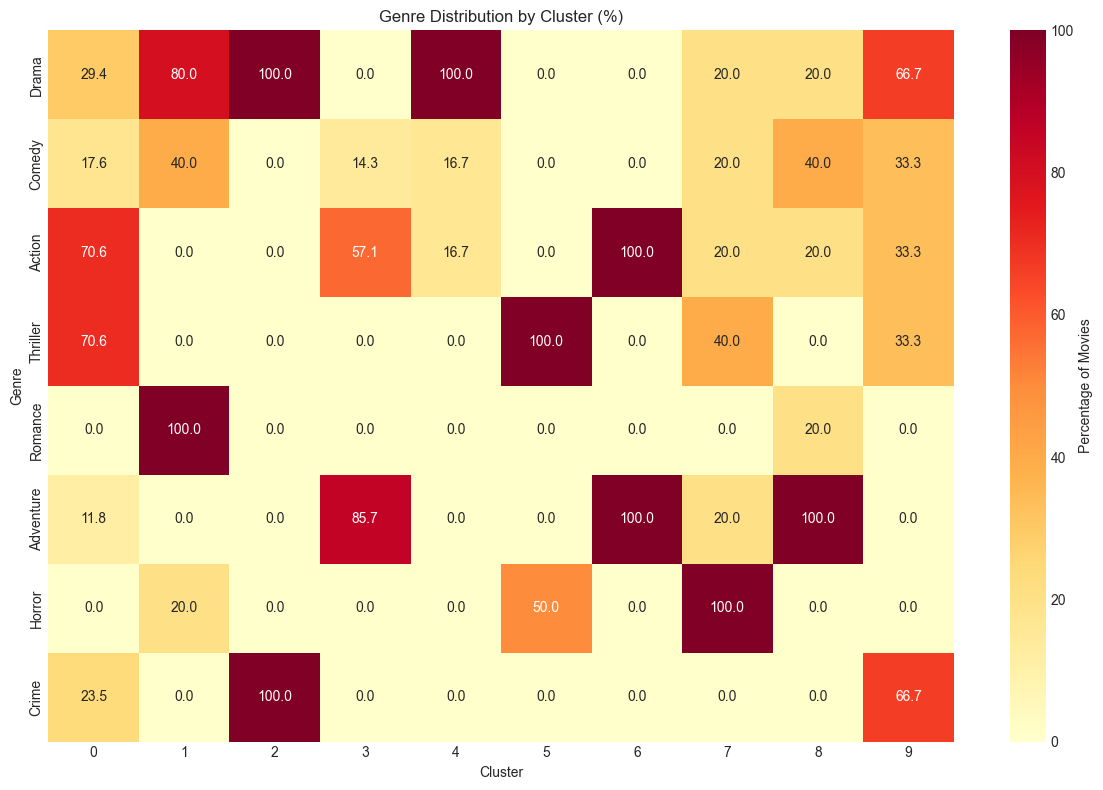

In [13]:
# Genre distribution by cluster
genre_cluster = pd.DataFrame()
for genre in top_genres:
    genre_cluster[genre] = df.groupby('cluster')[f'genre_{genre}'].mean() * 100

genre_cluster_T = genre_cluster.T

plt.figure(figsize=(12, 8))
sns.heatmap(genre_cluster_T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage of Movies'})
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.title('Genre Distribution by Cluster (%)')
plt.tight_layout()
plt.show()

## 7. Visualization (PCA for 2D)

In [14]:
# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Explained variance ratio: [0.23906576 0.13429579]
Total variance explained: 37.34%


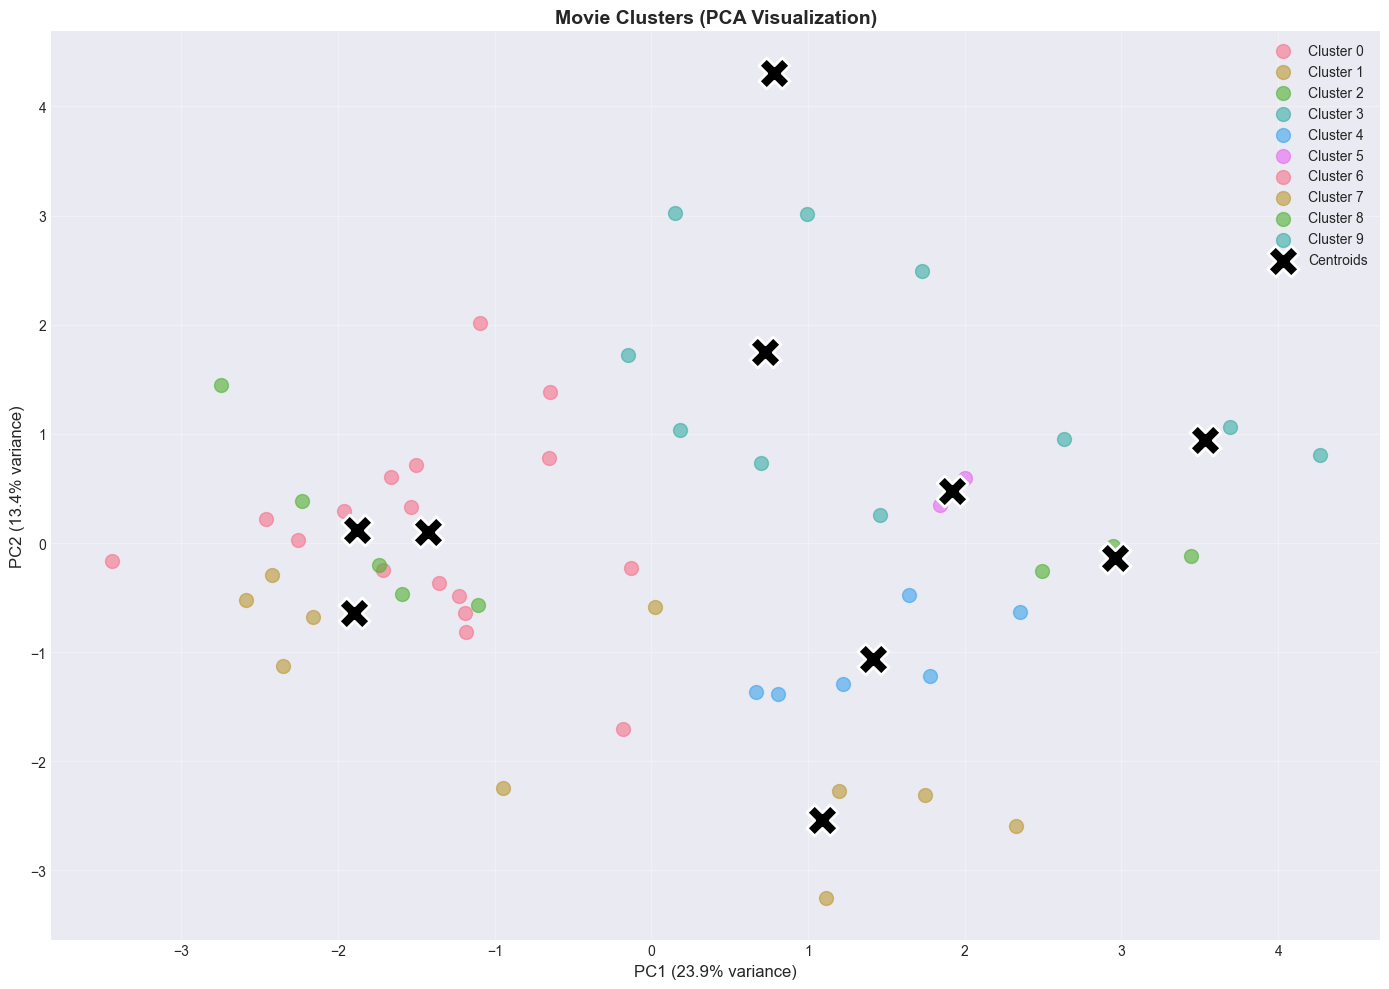

In [15]:
# Scatter plot with clusters
plt.figure(figsize=(14, 10))

# Plot each cluster with different color
for i in range(k_final):
    cluster_points = X_pca[df['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f'Cluster {i}', alpha=0.6, s=100)

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', marker='X', s=500, edgecolors='white', linewidths=2,
            label='Centroids', zorder=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Movie Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary & Insights

In [16]:
print("\n" + "="*80)
print("CLUSTERING SUMMARY")
print("="*80)
print(f"Number of clusters: {k_final}")
print(f"Average Silhouette Score: {silhouette_avg:.3f}")
print(f"Total movies clustered: {len(df)}")
print(f"\nCluster sizes:")
for i in range(k_final):
    count = (df['cluster'] == i).sum()
    percentage = count / len(df) * 100
    print(f"  Cluster {i}: {count} movies ({percentage:.1f}%)")

print("\n" + "="*80)


CLUSTERING SUMMARY
Number of clusters: 10
Average Silhouette Score: 0.175
Total movies clustered: 54

Cluster sizes:
  Cluster 0: 17 movies (31.5%)
  Cluster 1: 5 movies (9.3%)
  Cluster 2: 3 movies (5.6%)
  Cluster 3: 7 movies (13.0%)
  Cluster 4: 6 movies (11.1%)
  Cluster 5: 2 movies (3.7%)
  Cluster 6: 1 movies (1.9%)
  Cluster 7: 5 movies (9.3%)
  Cluster 8: 5 movies (9.3%)
  Cluster 9: 3 movies (5.6%)

